## Bitcoin

In [169]:
import keras 
import statsmodels.api as sm 

import json 
import numpy as np
import pandas as pd
import requests
import yfinance 
import seaborn as sea
import matplotlib.pyplot as plt

Será selecionado as seguintes colunas para predição do BTC:

* M1 : Moeda em circulação + depósitos à vista. Liquidez imediata na economia.
* unrate : Percentual da população economicamente ativa que está sem emprego. Indicador-chave do mercado de trabalho.
* Ações de tecnologia (Microsoft, AMD, Nvidia, Google, Facebook)
* FEDFUNDS: Taxa efetiva que bancos cobram uns aos outros para empréstimos overnight. Principal instrumento de política monetária do Fed.
* CIVPART : Percentual da população em idade ativa que está trabalhando ou procurando emprego.
* TDSP : Soma de todos os empréstimos das famílias: hipotecas, crédito pessoal, cartões, etc.

In [170]:
with open('api-key.json') as f:
    api = json.load(f)

In [171]:
f'https://api.stlouisfed.org/fred/series/observations?series_id=FEDFUNDS&api_key={api['key']}'

'https://api.stlouisfed.org/fred/series/observations?series_id=FEDFUNDS&api_key=dc7bef3cfd77ddbea2e77a3df484419f'

#### `FEDFUNDS`

In [172]:
response = requests.get(f'https://api.stlouisfed.org/fred/series/observations?series_id=FEDFUNDS&api_key={api["key"]}&file_type=json')

FEDFUNDS = pd.DataFrame(response.json()['observations'])[['date','value']]

Definindo data

In [173]:
FEDFUNDS['date'] = pd.to_datetime(FEDFUNDS['date'])

Definindo date como indice

In [174]:
FEDFUNDS.set_index('date',inplace=True)

E renomenando a coluna para o nome da series, no caso para FEDFUNDS

In [175]:
FEDFUNDS.columns = ['FEDFUNDS']

Passando para float

In [176]:
FEDFUNDS['FEDFUNDS'] = FEDFUNDS['FEDFUNDS'].astype(float)

Upsampling

In [177]:
FEDFUNDS =FEDFUNDS.resample('D').ffill()

> Será repetido o processo para os dados pegos no FRED

In [178]:
FEDFUNDS.tail()

,FEDFUNDS
date,
2025-07-28,4.33
2025-07-29,4.33
2025-07-30,4.33
2025-07-31,4.33
2025-08-01,4.33


#### `M1`

In [179]:
response = requests.get(f'https://api.stlouisfed.org/fred/series/observations?series_id=WM1NS&api_key={api["key"]}&file_type=json')

M1 = pd.DataFrame(response.json()['observations'])[['date','value']]

In [180]:
M1['date'] = pd.to_datetime(M1['date'])

M1.set_index('date',inplace=True)

M1.columns = ['M1']

M1['M1'] = M1['M1'].astype(float)

In [181]:
M1 = M1.resample('MS').first()

In [182]:
M1 = M1.resample('D').ffill()

In [183]:
M1.tail()

,M1
date,
2025-08-28,18886.4
2025-08-29,18886.4
2025-08-30,18886.4
2025-08-31,18886.4
2025-09-01,18885.6


#### `CIVPART`

In [184]:
response = requests.get(f'https://api.stlouisfed.org/fred/series/observations?series_id=CIVPART&api_key={api["key"]}&file_type=json')

CIVPART = pd.DataFrame(response.json()['observations'])[['date','value']]

In [185]:
CIVPART['date'] = pd.to_datetime(CIVPART['date'])

CIVPART.set_index('date',inplace=True)

CIVPART.columns = ['CIVPART']

CIVPART['CIVPART'] = CIVPART['CIVPART'].astype(float)

In [186]:
CIVPART = CIVPART.resample('D').ffill()

In [187]:
CIVPART.tail()

,CIVPART
date,
2025-07-28,62.2
2025-07-29,62.2
2025-07-30,62.2
2025-07-31,62.2
2025-08-01,62.3


#### `T10Y2Y`

In [188]:
response = requests.get(f'https://api.stlouisfed.org/fred/series/observations?series_id=T10Y2Y&api_key={api["key"]}&file_type=json')

T10Y2Y = pd.DataFrame(response.json()['observations'])[['date','value']]

In [189]:
def to_float(x):
    try:
        return float(x)
    except:
        return pd.NA

In [190]:
T10Y2Y['date'] = pd.to_datetime(T10Y2Y['date'])

T10Y2Y.set_index('date',inplace=True)

T10Y2Y.columns = ['T10Y2Y']

T10Y2Y['T10Y2Y'] = pd.to_numeric(T10Y2Y['T10Y2Y'].apply(to_float), errors='coerce')

In [191]:
T10Y2Y.isna().sum()

T10Y2Y    541
dtype: int64

In [192]:
T10Y2Y['T10Y2Y'] = T10Y2Y['T10Y2Y'].interpolate('linear', limit_direction='forward')

<Axes: xlabel='date'>

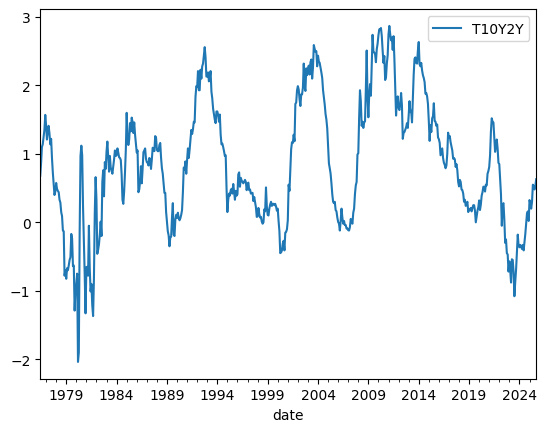

In [193]:
T10Y2Y.resample('MS').first().plot()

In [194]:
T10Y2Y.tail()

,T10Y2Y
date,
2025-09-18,0.54
2025-09-19,0.57
2025-09-22,0.54
2025-09-23,0.59
2025-09-24,0.59


#### `UNRATE`

In [195]:
response = requests.get(f'https://api.stlouisfed.org/fred/series/observations?series_id=UNRATE&api_key={api["key"]}&file_type=json')

UNRATE = pd.DataFrame(response.json()['observations'])[['date','value']]

In [196]:
UNRATE['date'] = pd.to_datetime(UNRATE['date'])

UNRATE.set_index('date',inplace=True)

UNRATE.columns = ['UNRATE']

UNRATE['UNRATE'] = UNRATE['UNRATE'].astype(float)

In [197]:
UNRATE = UNRATE.resample('D').ffill()

In [198]:
UNRATE.tail()

,UNRATE
date,
2025-07-28,4.2
2025-07-29,4.2
2025-07-30,4.2
2025-07-31,4.2
2025-08-01,4.3


#### `TDSP`

In [199]:
response = requests.get(f'https://api.stlouisfed.org/fred/series/observations?series_id=DTB3&api_key={api["key"]}&file_type=json')

DTB3 = pd.DataFrame(response.json()['observations'])[['date','value']]

In [200]:
DTB3['date'] = pd.to_datetime(DTB3['date'])

DTB3.set_index('date',inplace=True)

DTB3.columns = ['DTB3']

DTB3['DTB3'] = pd.to_numeric(DTB3['DTB3'].apply(to_float), errors='coerce')

In [201]:
DTB3.isna().sum()

DTB3    789
dtype: int64

In [202]:
DTB3['DTB3'] = DTB3['DTB3'].interpolate('linear', limit_direction='forward')

`Dados completo do fred`

In [203]:
dados_fred = pd.concat([CIVPART, T10Y2Y, UNRATE, DTB3, FEDFUNDS, M1],axis=1).dropna()

In [204]:
dados_fred

,CIVPART,T10Y2Y,UNRATE,DTB3,FEDFUNDS,M1
date,,,,,,
1976-06-01,61.5,0.68,7.6,5.55,5.48,295.1
1976-06-02,61.5,0.71,7.6,5.57,5.48,295.1
1976-06-03,61.5,0.70,7.6,5.52,5.48,295.1
1976-06-04,61.5,0.77,7.6,5.46,5.48,295.1
1976-06-07,61.5,0.79,7.6,5.45,5.48,295.1
...,...,...,...,...,...,...
2025-07-28,62.2,0.51,4.2,4.24,4.33,18861.8
2025-07-29,62.2,0.48,4.2,4.24,4.33,18861.8
2025-07-30,62.2,0.44,4.2,4.25,4.33,18861.8


## Dados da bolsa

In [205]:
# Microsoft, AMD, Nvidia, Google, Facebook, Apple, BTC

MSFT  = yfinance.download('MSFT' , start='2014-09-17', end='2025-09-22', interval='1d', auto_adjust=True)['Close']
AMD   = yfinance.download('AMD'  , start='2014-09-17', end='2025-09-22', interval='1d', auto_adjust=True)['Close']
NVDA  = yfinance.download('NVDA' , start='2014-09-17', end='2025-09-22', interval='1d', auto_adjust=True)['Close']
GOOGL = yfinance.download('GOOGL', start='2014-09-17', end='2025-09-22', interval='1d', auto_adjust=True)['Close']
FB    = yfinance.download('FB'   , start='2014-09-17', end='2025-09-22', interval='1d', auto_adjust=True)['Close']
AAPL  = yfinance.download('AAPL' , start='2014-09-17', end='2025-09-22', interval='1d', auto_adjust=True)['Close']
BTC   = yfinance.download('BTC-USD', start='2014-09-17', end='2025-09-22', interval='1d', auto_adjust=True)['Close']
SP500 = yfinance.download('^GSPC'  , start='2014-09-17', end='2025-09-22', interval='1d', auto_adjust=True)['Close']

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [206]:
data = pd.concat([MSFT, AMD, NVDA, GOOGL, AAPL, BTC, SP500], axis=1)
data.columns = ['MSFT', 'AMD', 'NVDA', 'GOOGL', 'AAPL', 'BTC', 'SP500']

In [207]:
dataset = pd.concat([data, dados_fred], axis=1).dropna()

In [208]:
dataset

,MSFT,AMD,NVDA,GOOGL,AAPL,BTC,SP500,CIVPART,T10Y2Y,UNRATE,DTB3,FEDFUNDS,M1
2014-09-17,39.479092,3.820000,0.457586,29.461304,22.443947,457.334015,2001.569946,62.8,2.03,5.9,0.02,0.09,2923.1
2014-09-18,39.614868,3.880000,0.464515,29.658939,22.490355,424.440002,2011.359985,62.8,2.04,5.9,0.02,0.09,2923.1
2014-09-19,40.327744,3.810000,0.455913,30.062656,22.306963,394.795990,2010.400024,62.8,2.00,5.9,0.02,0.09,2923.1
2014-09-22,39.937363,3.760000,0.451373,29.658939,22.329048,402.152008,1994.290039,62.8,1.99,5.9,0.01,0.09,2923.1
2014-09-23,39.513035,3.690000,0.449462,29.356525,22.678158,435.790985,1982.770020,62.8,1.97,5.9,0.01,0.09,2923.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-07-28,511.658875,173.660004,176.740036,192.407913,213.807358,117924.476562,6389.770020,62.2,0.51,4.2,4.24,4.33,18861.8
2025-07-29,511.728760,177.440002,175.500092,195.575073,211.030502,117922.148438,6370.859863,62.2,0.48,4.2,4.24,4.33,18861.8
2025-07-30,512.397644,179.509995,179.259903,196.354385,208.813019,117831.187500,6362.899902,62.2,0.44,4.2,4.25,4.33,18861.8
2025-07-31,532.624390,176.309998,177.859970,191.728516,207.334702,115758.203125,6339.390137,62.2,0.43,4.2,4.24,4.33,18861.8


In [218]:
for i in [1, 3, 6, 12]:
    dataset['BTC_{}'.format(i)] = dataset['BTC'].diff(5*i)

In [219]:
BTC = np.log1p(dataset['BTC']).diff(5).shift(-5)
X   = dataset.drop('BTC', axis=1)
X   = np.log(X).diff(5)

c:\Users\mateu\Documents\Norton\Projetos GIT\machine-learning\venv\Lib\site-packages\pandas\core\internals\blocks.py:395: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
c:\Users\mateu\Documents\Norton\Projetos GIT\machine-learning\venv\Lib\site-packages\pandas\core\internals\blocks.py:395: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


In [220]:
dataset_ = pd.concat([X, BTC], axis=1).dropna()
dataset_.head()

,MSFT,AMD,NVDA,GOOGL,AAPL,SP500,CIVPART,T10Y2Y,UNRATE,DTB3,FEDFUNDS,M1,BTC_1,BTC_3,BTC_6,BTC_12,BTC
2015-07-07,-0.001579,-0.112987,-0.016537,0.016091,0.009272,0.011452,-0.001596,0.000000,-0.019048,0.000000,0.0,-0.019988,-0.096968,0.027918,0.284349,2.004753,0.076547
2015-07-08,0.002037,-0.177334,-0.023140,0.003069,-0.023066,-0.007996,-0.001596,-0.023670,-0.019048,0.693147,0.0,-0.019988,-0.889670,-0.536849,0.117249,1.807425,0.053875
2015-07-09,0.001574,-0.200671,-0.049746,0.002482,-0.052957,-0.012648,0.000000,-0.011561,0.000000,1.098612,0.0,0.000000,-0.534730,-0.402184,0.180326,2.219437,0.032265
2015-07-10,0.004718,-0.255275,-0.033362,0.015896,-0.025310,-0.000077,0.000000,0.005666,0.000000,0.000000,0.0,0.000000,0.849052,0.333612,0.797325,1.771030,-0.019147
2015-07-13,0.025577,-0.231274,-0.014482,0.046744,-0.002702,0.014797,0.000000,0.028988,0.000000,0.000000,0.0,0.000000,-0.099629,0.194842,0.489487,0.917804,-0.045635


In [221]:
dataset_ = dataset_[::5]

In [222]:
Y = dataset_['BTC']
X = dataset_.drop('BTC', axis=1)

In [223]:
train_size = int(len(dataset_) * 0.8)

In [224]:
xtrain, xtest, ytrain, ytest = X[:train_size], X[train_size:], Y[:train_size], Y[train_size:]

`Arima`

In [225]:
from sklearn.linear_model import LinearRegression

In [226]:
model = LinearRegression()
model.fit(xtrain, ytrain)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [227]:
pred = model.predict(xtest)

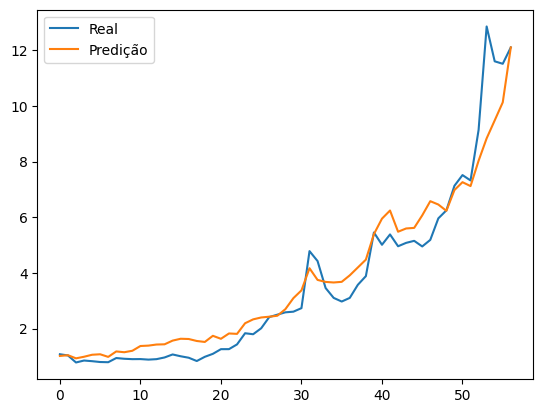

In [228]:
plt.plot(np.exp(ytrain.values).cumprod(), label='Real')
plt.plot(np.exp(model.predict(xtrain)).cumprod(), label='Predição')
plt.legend()
plt.show()

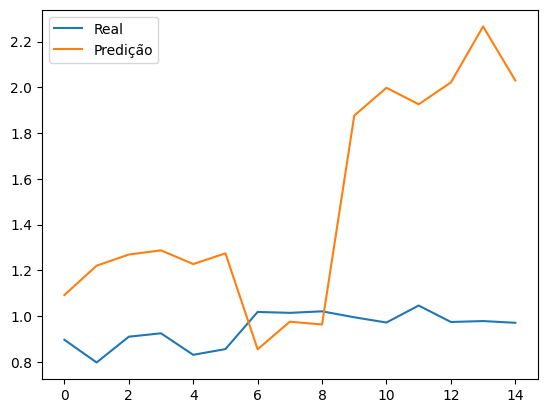

In [229]:
plt.plot(np.exp(ytest.values).cumprod(), label='Real')
plt.plot(np.exp(pred).cumprod(), label='Predição')
plt.legend()
plt.show()

`Arima`

In [230]:
arima = sm.tsa.ARIMA(ytrain, order=(1,0,1), exog=xtrain)
arima = arima.fit()

c:\Users\mateu\Documents\Norton\Projetos GIT\machine-learning\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\mateu\Documents\Norton\Projetos GIT\machine-learning\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\mateu\Documents\Norton\Projetos GIT\machine-learning\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\mateu\Documents\Norton\Projetos GIT\machine-learning\venv\Lib\site-packages\statsmodels\tsa\statespace\sar

In [231]:
pred = arima.predict(start=len(ytrain), end=len(ytrain)+len(ytest)-1, exog=xtest)

c:\Users\mateu\Documents\Norton\Projetos GIT\machine-learning\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\mateu\Documents\Norton\Projetos GIT\machine-learning\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


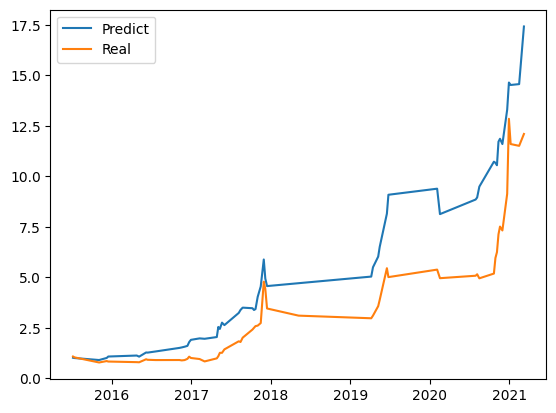

In [232]:
plt.plot(np.exp(arima.fittedvalues).cumprod(), label='Predict')
plt.plot(np.exp(ytrain).cumprod(), label='Real')
plt.legend()
plt.show()

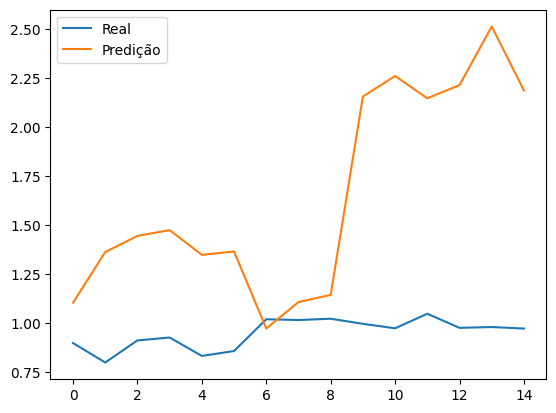

In [233]:
plt.plot(np.exp(ytest.values).cumprod(), label='Real')
plt.plot(np.exp(pred.values).cumprod(), label='Predição')
plt.legend()
plt.show()

In [234]:
from

SyntaxError: invalid syntax (1763543092.py, line 1)